<a href="https://colab.research.google.com/github/harshilpatel350/guardian-news-clustering-2024/blob/main/NewsCluster_2024_Unsupervised_Topic_%26_Sentiment_Discovery_from_Guardian_Headlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import datetime
import csv
import time

def scrape_guardian_day(date_obj):
    url = f"https://www.theguardian.com/theguardian/{date_obj.year}/{date_obj.strftime('%b').lower()}/{date_obj.day:02d}"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        return []

    soup = BeautifulSoup(response.content, "html.parser")
    articles = []

    for link in soup.find_all("a", class_="fc-item__link"):
        headline = link.find("span", class_="js-headline-text")
        if headline:
            articles.append({
                "date": date_obj.strftime("%Y-%m-%d"),
                "headline": headline.text.strip(),
                "url": link["href"]
            })

    return articles

# Define date range for 2024
start_date = datetime.date(2024, 1, 1)
end_date = datetime.date(2024, 12, 31)

# Write to CSV
with open("guardian_2024_articles.csv", "w", newline='', encoding='utf-8') as csvfile:
    fieldnames = ["date", "headline", "url"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    current_date = start_date
    while current_date <= end_date:
        try:
            articles = scrape_guardian_day(current_date)
            for article in articles:
                writer.writerow(article)
            print(f"Scraped: {current_date} ({len(articles)} articles)")
        except Exception as e:
            print(f"Error on {current_date}: {e}")

        current_date += datetime.timedelta(days=1)
        time.sleep(1)  # Respectful scraping delay

print("Finished scraping The Guardian 2024 archive.")


Scraped: 2024-01-01 (29 articles)
Scraped: 2024-01-02 (32 articles)
Scraped: 2024-01-03 (35 articles)
Scraped: 2024-01-04 (40 articles)
Scraped: 2024-01-05 (41 articles)
Scraped: 2024-01-06 (40 articles)
Scraped: 2024-01-07 (32 articles)
Scraped: 2024-01-08 (37 articles)
Scraped: 2024-01-09 (40 articles)
Scraped: 2024-01-10 (44 articles)
Scraped: 2024-01-11 (44 articles)
Scraped: 2024-01-12 (35 articles)
Scraped: 2024-01-13 (41 articles)
Scraped: 2024-01-14 (32 articles)
Scraped: 2024-01-15 (30 articles)
Scraped: 2024-01-16 (40 articles)
Scraped: 2024-01-17 (39 articles)
Scraped: 2024-01-18 (39 articles)
Scraped: 2024-01-19 (38 articles)
Scraped: 2024-01-20 (48 articles)
Scraped: 2024-01-21 (32 articles)
Scraped: 2024-01-22 (35 articles)
Scraped: 2024-01-23 (39 articles)
Scraped: 2024-01-24 (42 articles)
Scraped: 2024-01-25 (37 articles)
Scraped: 2024-01-26 (34 articles)
Scraped: 2024-01-27 (45 articles)
Scraped: 2024-01-28 (32 articles)
Scraped: 2024-01-29 (33 articles)
Scraped: 2024-

In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Only run once
nltk.download("vader_lexicon")

# Load the scraped headlines
df = pd.read_csv("guardian_2024_articles.csv")

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis
def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return pd.Series([
        scores['neg'],
        scores['neu'],
        scores['pos'],
        scores['compound']
    ])

# Add new columns to DataFrame
df[['neg', 'neu', 'pos', 'compound']] = df['headline'].apply(analyze_sentiment)

# Save the result
df.to_csv("guardian_2024_sentiment.csv", index=False)

print("Sentiment analysis completed and saved to 'guardian_2024_sentiment.csv'.")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment analysis completed and saved to 'guardian_2024_sentiment.csv'.


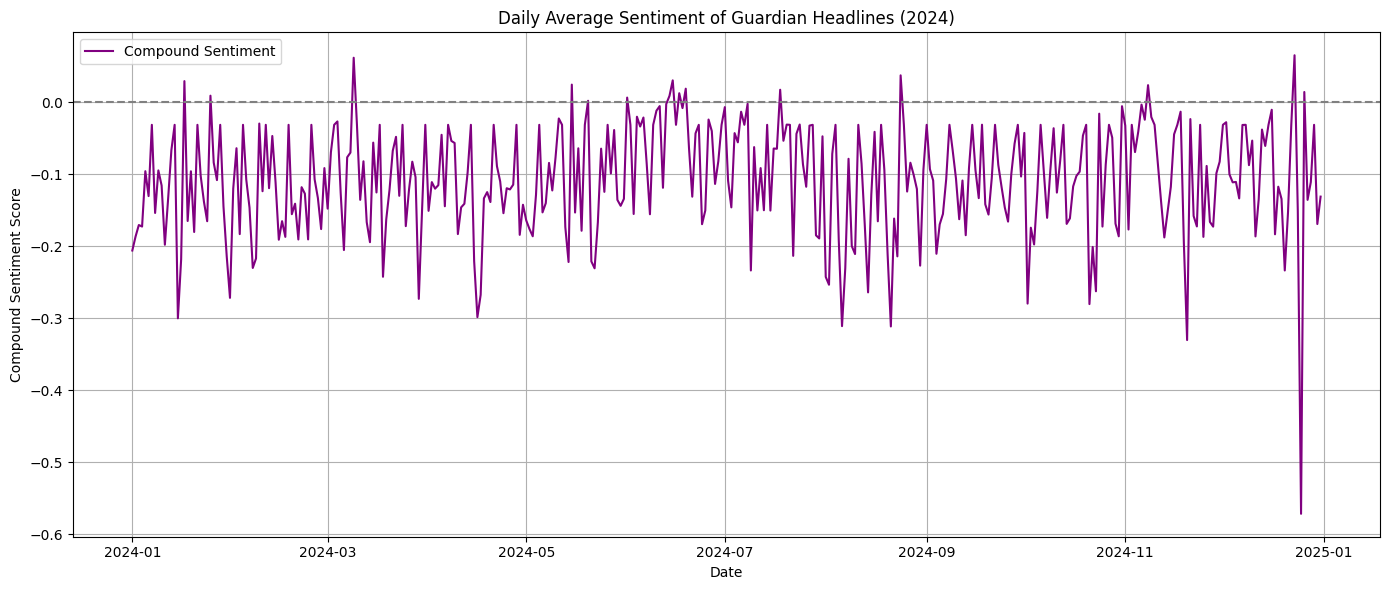

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data with sentiment scores
df = pd.read_csv("guardian_2024_sentiment.csv")

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by date, compute average sentiment
daily_sentiment = df.groupby('date').mean(numeric_only=True)[['neg', 'neu', 'pos', 'compound']]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(daily_sentiment.index, daily_sentiment['compound'], label='Compound Sentiment', color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Daily Average Sentiment of Guardian Headlines (2024)")
plt.xlabel("Date")
plt.ylabel("Compound Sentiment Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load full dataset
df = pd.read_csv("guardian_2024_sentiment.csv")

# Example topics: politics, climate, war, tech
topics = ['politics', 'climate', 'environment', 'tech', 'war', 'election']

# Add a new column for detected topic
def detect_topic(url):
    for topic in topics:
        if topic in url.lower():
            return topic
    return 'other'

df['topic'] = df['url'].apply(detect_topic)

# Save filtered version
df.to_csv("guardian_2024_sentiment_with_topics.csv", index=False)


In [ ]:
# Average sentiment per topic
topic_sentiment = df.groupby('topic').mean(numeric_only=True)[['compound']]
print(topic_sentiment.sort_values(by='compound'))


             compound
topic                
war         -0.332698
climate     -0.250007
other       -0.113057
politics    -0.053401
environment -0.052751
tech        -0.038638
election     0.035152


In [ ]:
# Top 5 most negative days
neg_days = df.groupby('date')['compound'].mean().sort_values().head(5)

# Top 5 most positive days
pos_days = df.groupby('date')['compound'].mean().sort_values(ascending=False).head(5)

print("Most Negative Days:")
print(neg_days)

print("\nMost Positive Days:")
print(pos_days)


Most Negative Days:
date
2024-12-25   -0.571300
2024-11-20   -0.330200
2024-08-21   -0.311338
2024-08-06   -0.310886
2024-01-15   -0.300043
Name: compound, dtype: float64

Most Positive Days:
date
2024-12-23    0.064991
2024-03-09    0.061549
2024-08-24    0.037127
2024-06-15    0.030145
2024-01-17    0.029113
Name: compound, dtype: float64


In [ ]:
pip install wordcloud


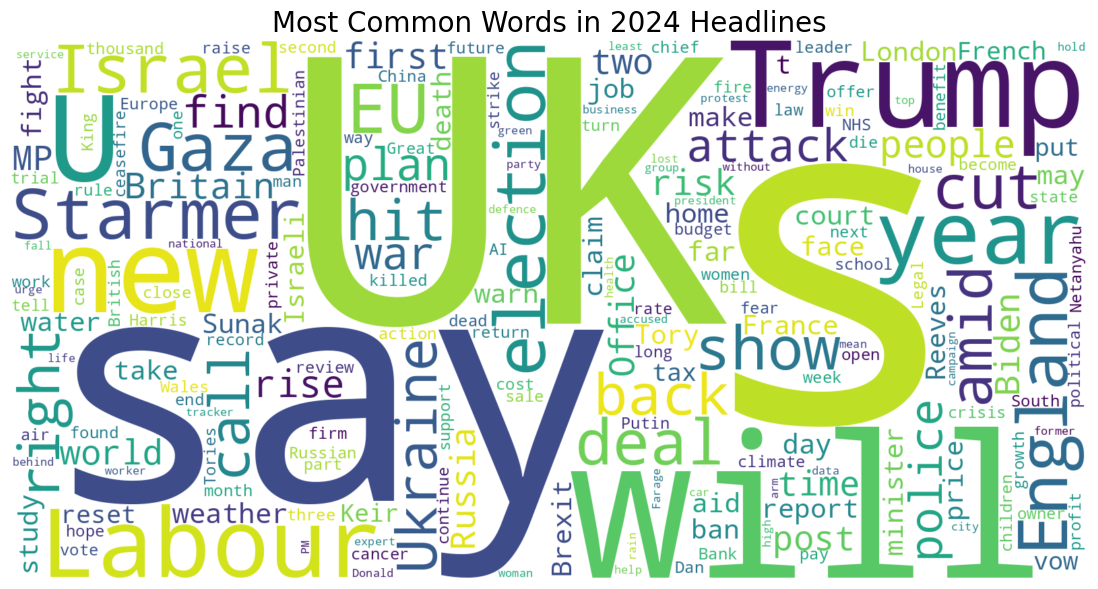

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all headlines
all_text = " ".join(df['headline'].dropna().astype(str).tolist())

# Generate WordCloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in 2024 Headlines", fontsize=20)
plt.show()


In [ ]:
import ipywidgets as widgets
from IPython.display import display
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported for df

# Assuming df is already loaded from a previous cell
# Load full dataset
# df = pd.read_csv("guardian_2024_sentiment_with_topics.csv") # Uncomment if running this cell independently

def show_topic_wordcloud(topic):
    """Generates and displays a word cloud for headlines of a specific topic."""
    # Filter headlines by topic
    topic_df = df[df['topic'] == topic]

    if topic_df.empty:
        print(f"No headlines found for topic: {topic}")
        return

    # Concatenate all headlines for the selected topic
    all_text_topic = " ".join(topic_df['headline'].dropna().astype(str).tolist())

    if not all_text_topic:
        print(f"No text found for word cloud for topic: {topic}")
        return

    # Generate WordCloud
    wordcloud_topic = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate(all_text_topic)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud_topic, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Common Words in {topic.capitalize()} Headlines (2024)", fontsize=20)
    plt.show()

topics = df['topic'].unique().tolist()

widgets.interact(show_topic_wordcloud, topic=widgets.Dropdown(options=topics, value='politics'))

interactive(children=(Dropdown(description='topic', options=('politics', 'environment', 'other', 'election', '…

<function __main__.show_topic_wordcloud(topic)>

In [ ]:
wordcloud.to_file("guardian_wordcloud_2024.png")


In [ ]:
daily_sentiment = df.groupby('date')['compound'].mean()

print("📉 Most Negative Days:")
print(daily_sentiment.sort_values().head(5))

print("\n📈 Most Positive Days:")
print(daily_sentiment.sort_values(ascending=False).head(5))


📉 Most Negative Days:
date
2024-12-25   -0.571300
2024-11-20   -0.330200
2024-08-21   -0.311338
2024-08-06   -0.310886
2024-01-15   -0.300043
Name: compound, dtype: float64

📈 Most Positive Days:
date
2024-12-23    0.064991
2024-03-09    0.061549
2024-08-24    0.037127
2024-06-15    0.030145
2024-01-17    0.029113
Name: compound, dtype: float64


In [ ]:
summary_df = df.groupby('topic')[['neg', 'neu', 'pos', 'compound']].mean().sort_values(by='compound')
summary_df.to_csv("guardian_2024_topic_sentiment_summary.csv")
summary_df


,neg,neu,pos,compound
topic,,,,
war,0.257493,0.667220,0.075292,-0.332698
climate,0.186789,0.749735,0.063490,-0.250007
other,0.132487,0.793706,0.073808,-0.113057
politics,0.099791,0.824438,0.075763,-0.053401
environment,0.091340,0.846151,0.062522,-0.052751
tech,0.104848,0.808507,0.086652,-0.038638
election,0.115097,0.759222,0.125686,0.035152


<Axes: title={'center': 'Topic Frequency Over Time (7-day avg)'}, xlabel='date'>

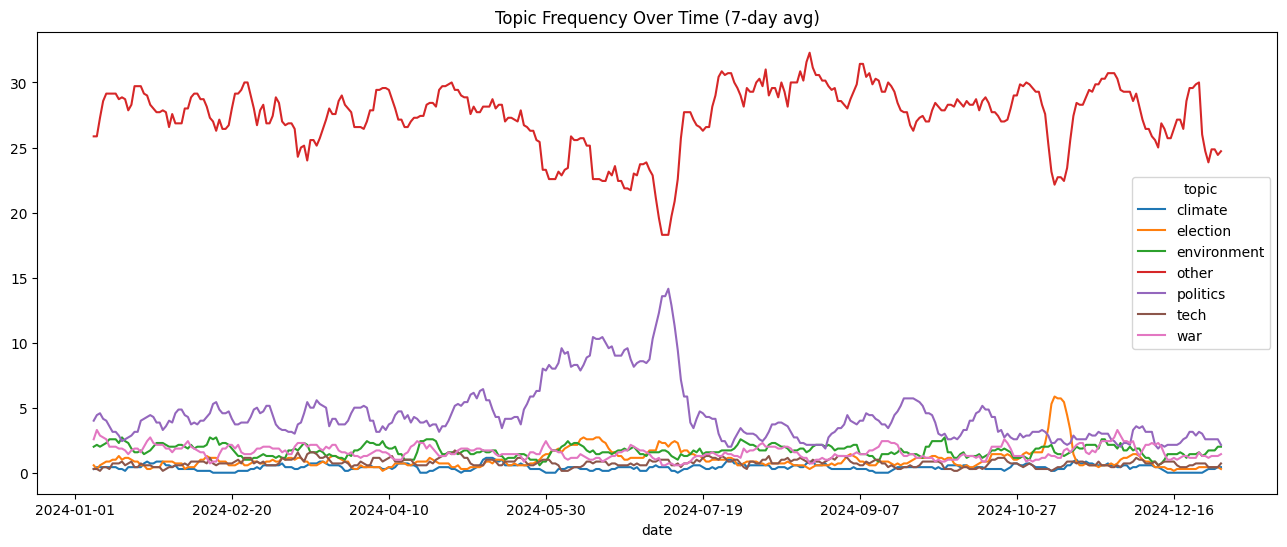

In [ ]:
topic_trend = df.groupby(['date', 'topic']).size().unstack(fill_value=0)
topic_trend.rolling(window=7).mean().plot(figsize=(16, 6), title="Topic Frequency Over Time (7-day avg)")


In [ ]:
pip install nrclex


In [ ]:
# Then re-run the cell that caused the error
from nrclex import NRCLex
import pandas as pd # Ensure pandas is imported
import nltk # Import nltk

# Download the required NLTK resource for tokenization if not already present
# Handle the LookupError directly
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    print("NLTK 'punkt_tab' not found. Downloading...")
    nltk.download('punkt_tab')


def get_emotions(text):
    # Get raw emotion scores
    raw_emotions = NRCLex(text).raw_emotion_scores

    # Define the expected emotion columns
    expected_emotions = ['anger', 'fear', 'joy', 'sadness', 'trust']

    # Create a dictionary with default values (0) for all expected emotions
    # Then update it with the raw scores if they exist
    emotions = {emotion: raw_emotions.get(emotion, 0) for emotion in expected_emotions}

    # Return a Series with the expected columns in a consistent order
    return pd.Series(emotions, index=expected_emotions)

# Apply the function to the 'headline' column
df[['anger', 'fear', 'joy', 'sadness', 'trust']] = df['headline'].apply(get_emotions)

NLTK 'punkt_tab' not found. Downloading...


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    people = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    orgs = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    return pd.Series([people, orgs])

df[['people', 'organizations']] = df['headline'].apply(extract_entities)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['headline'])

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)


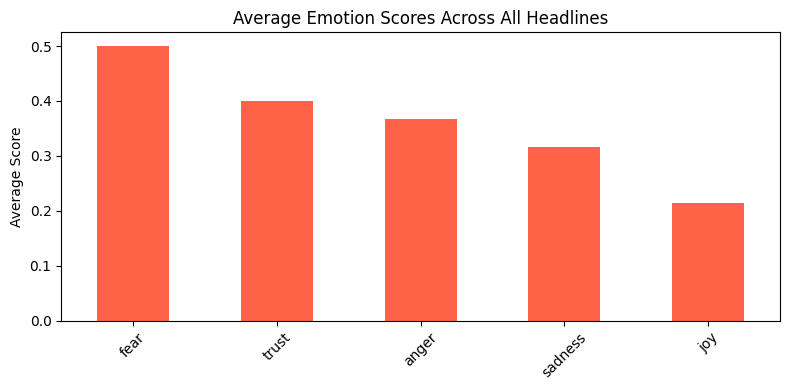

In [ ]:
import matplotlib.pyplot as plt

df[['anger', 'fear', 'joy', 'sadness', 'trust']].mean().sort_values(ascending=False).plot(
    kind='bar', figsize=(8, 4), color='tomato', title="Average Emotion Scores Across All Headlines"
)
plt.xticks(rotation=45)
plt.ylabel("Average Score")
plt.tight_layout()
plt.show()


In [ ]:
# Show headlines with their recognized entities
df[['headline', 'people', 'organizations']].dropna().head(10)


,headline,people,organizations
0,Tories express alarm at Dominic Cummings’s ‘se...,[Rishi Sunak],[Dominic Cummings’s]
1,Great Ormond Street to look at home air pollut...,[],[]
2,‘Incredible kid’: Littler takes aim at world d...,[Littler],[]
3,Venice to limit tourist group size to 25 to pr...,[],[]
4,Queen Margrethe II of Denmark announces surpri...,[],[]
5,Civil servant at MoD alleges sexual assaults b...,[],[]
6,Smokers twice as likely to quit by using cytis...,[],[]
7,Judicial review hearing granted over XL bully ban,[],"[Judicial, XL]"
8,‘Absolute mayhem’: Eurostar passengers tell of...,[],[Eurostar]
9,New Year’s Eve fireworks cancelled as heavy ra...,[],[]


In [ ]:
from collections import Counter

# Flatten lists of names
people = Counter([name for sublist in df['people'].dropna() for name in sublist])
orgs = Counter([org for sublist in df['organizations'].dropna() for org in sublist])

# Show most common
print("Top People:", people.most_common(5))
print("Top Organizations:", orgs.most_common(5))


Top People: [('Keir Starmer', 138), ('Putin', 118), ('Biden', 118), ('Netanyahu', 114), ('Brexit', 78)]
Top Organizations: [('EU', 428), ('Trump', 280), ('Labour', 266), ('NHS', 125), ('UN', 86)]


In [ ]:
# Show 2 headlines per cluster
for i in range(5):
    print(f"\nCluster {i} Headlines:")
    sample = df[df['cluster'] == i]['headline'].head(2).tolist()
    for headline in sample:
        print("•", headline)



Cluster 0 Headlines:
• ‘Tiger King’ Joe Exotic pleads for Trump pardon after husband deported
• ‘Tiger King’ Joe Exotic pleads for Trump pardon after husband deported

Cluster 1 Headlines:
• Russia says strikes on Kharkiv were reaction to Ukraine’s attack on Belgorod
• Xi Jinping says Chinese business having ‘tough time’ in new year message

Cluster 2 Headlines:
• New Year’s Eve fireworks cancelled as heavy rain and high winds buffet UK
• Cyber-hackers target UK nuclear waste company RWM

Cluster 3 Headlines:
• Tories express alarm at Dominic Cummings’s ‘secret election talks’ with Rishi Sunak
• Great Ormond Street to look at home air pollution when diagnosing illnesses

Cluster 4 Headlines:
• ‘Jobs will be next’: TV ad slump prompts more fear among staff
• NHS trusts accused of exaggerating staff shortages to weaken impact of strike


In [ ]:
df['cluster'].value_counts().sort_index()


,count
cluster,
0,52
1,1052
2,1396
3,10999
4,161


In [ ]:
import numpy as np

# Get feature names (words from TF-IDF)
words = vectorizer.get_feature_names_out()

# For each cluster, get top N keywords
def get_top_keywords(model, words, n=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    top_words = {}
    for i in range(model.n_clusters):
        top = [words[ind] for ind in order_centroids[i, :n]]
        top_words[i] = top
    return top_words

top_keywords = get_top_keywords(kmeans, words)


In [ ]:
# View top keywords per cluster
for i in range(kmeans.n_clusters):
    print(f"\n📚 Cluster {i}: {', '.join(top_keywords[i])}")
    sample = df[df['cluster'] == i]['headline'].head(3).tolist()
    for h in sample:
        print("   •", h)



📚 Cluster 0: exotic, pardon, deported, tiger, pleads, husband, joe, king, trump, experts
   • ‘Tiger King’ Joe Exotic pleads for Trump pardon after husband deported
   • ‘Tiger King’ Joe Exotic pleads for Trump pardon after husband deported
   • ‘Tiger King’ Joe Exotic pleads for Trump pardon after husband deported

📚 Cluster 1: says, england, 64bn, trusts, opaque, diagnosis, world, biden, prostate, hidden
   • Russia says strikes on Kharkiv were reaction to Ukraine’s attack on Belgorod
   • Xi Jinping says Chinese business having ‘tough time’ in new year message
   • Michelle Mone’s husband says couple being ‘hung out to dry’ by ministers

📚 Cluster 2: uk, deal, eu, mean, erasmus, fishing, jobs, threaten, banking, action
   • New Year’s Eve fireworks cancelled as heavy rain and high winds buffet UK
   • Cyber-hackers target UK nuclear waste company RWM
   • Film, TV and video-game producers to get more generous UK tax relief

📚 Cluster 3: trump, labour, new, starmer, election, englan

In [ ]:
cluster_summary = df.groupby('cluster').agg({
    'headline': 'count',
    'compound': 'mean'
}).rename(columns={'headline': 'count', 'compound': 'avg_sentiment'})

# Add top words
cluster_summary['top_keywords'] = cluster_summary.index.map(lambda i: ", ".join(top_keywords[i]))
cluster_summary


,count,avg_sentiment,top_keywords
cluster,,,
0,52,0.318200,"exotic, pardon, deported, tiger, pleads, husba..."
1,1052,-0.099128,"says, england, 64bn, trusts, opaque, diagnosis..."
2,1396,-0.090313,"uk, deal, eu, mean, erasmus, fishing, jobs, th..."
3,10999,-0.113742,"trump, labour, new, starmer, election, england..."
4,161,-0.117175,"public, staff, uk, sector, pay, services, labo..."


<ipython-input-45-f02c7fa27994>:7: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


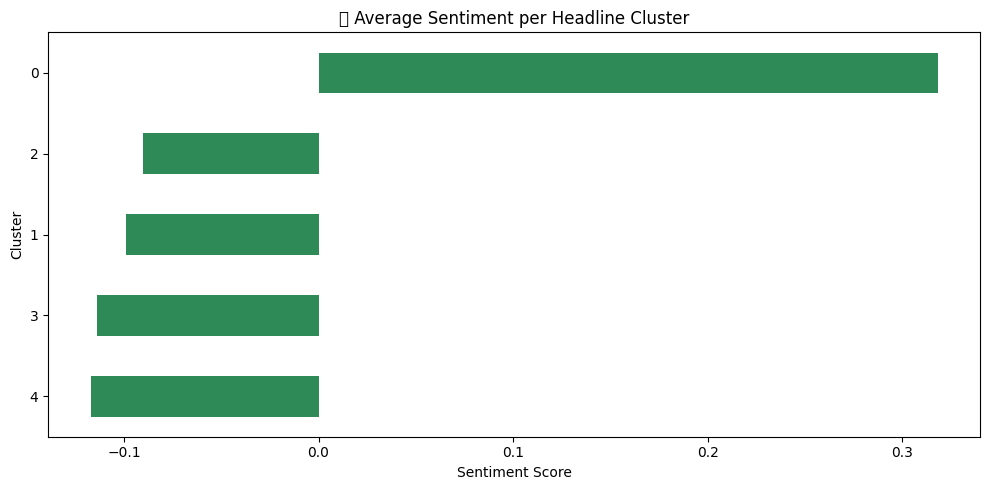

In [ ]:
import matplotlib.pyplot as plt

cluster_summary.sort_values('avg_sentiment')['avg_sentiment'].plot(kind='barh', figsize=(10, 5), color='seagreen')
plt.title("📊 Average Sentiment per Headline Cluster")
plt.xlabel("Sentiment Score")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


<ipython-input-46-2168fa1c8bfe>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('cluster').apply(lambda x: x.sample(min(len(x), 5))).reset_index(drop=True)
<ipython-input-46-2168fa1c8bfe>:30: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-2168fa1c8bfe>:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128240 (\N{NEWSPAPER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


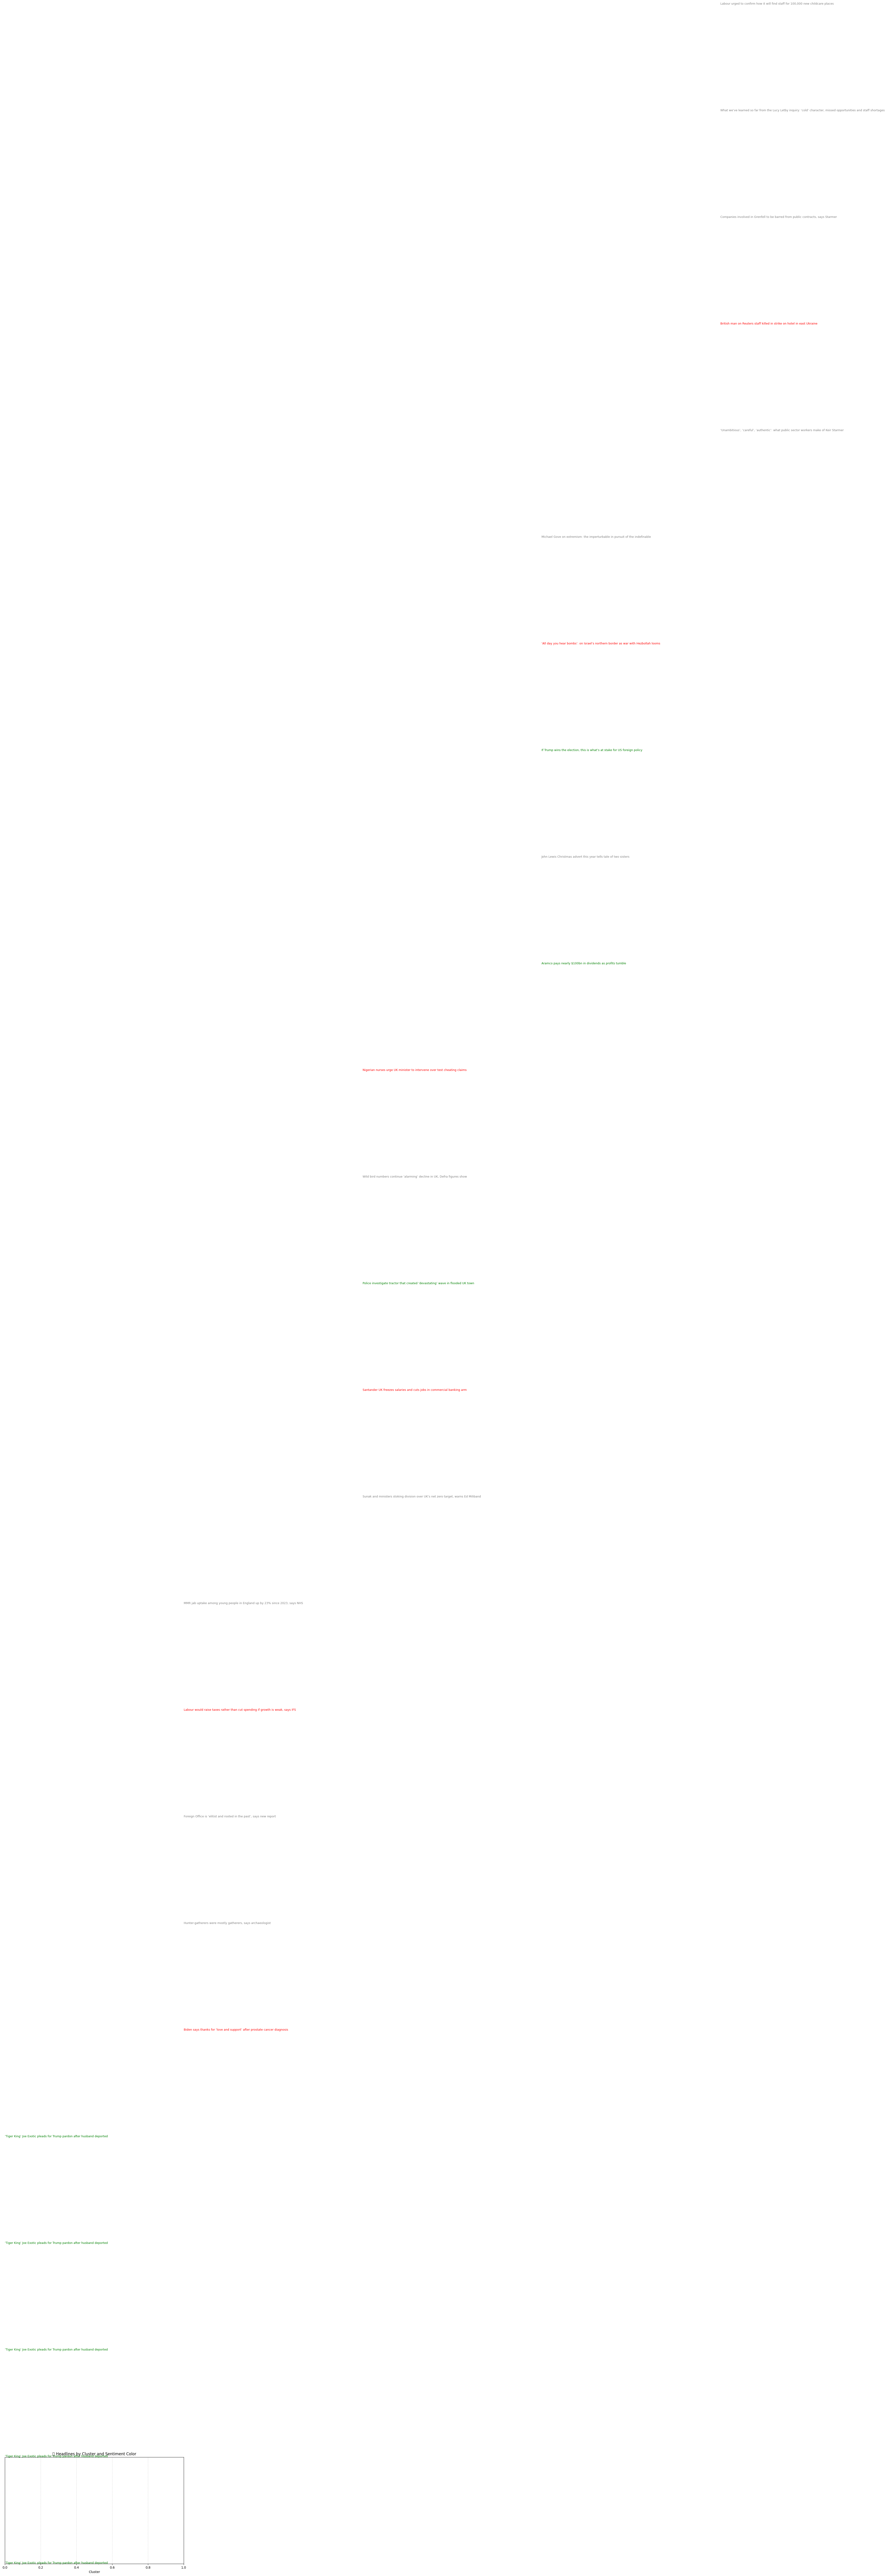

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a smaller sample for better readability
sample_df = df.groupby('cluster').apply(lambda x: x.sample(min(len(x), 5))).reset_index(drop=True)

# Sort by cluster
sample_df = sample_df.sort_values(['cluster', 'compound'])

# Set color palette based on sentiment
def get_sentiment_color(score):
    if score > 0.2:
        return 'green'
    elif score < -0.2:
        return 'red'
    else:
        return 'gray'

sample_df['color'] = sample_df['compound'].apply(get_sentiment_color)

# Plot
plt.figure(figsize=(10, 6))
for idx, row in sample_df.iterrows():
    plt.text(row['cluster'], idx, row['headline'], color=row['color'], fontsize=9)

plt.yticks([])
plt.xlabel("Cluster")
plt.title("📰 Headlines by Cluster and Sentiment Color")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
!pip install umap-learn


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-48-3f3f871eab2a>:14: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


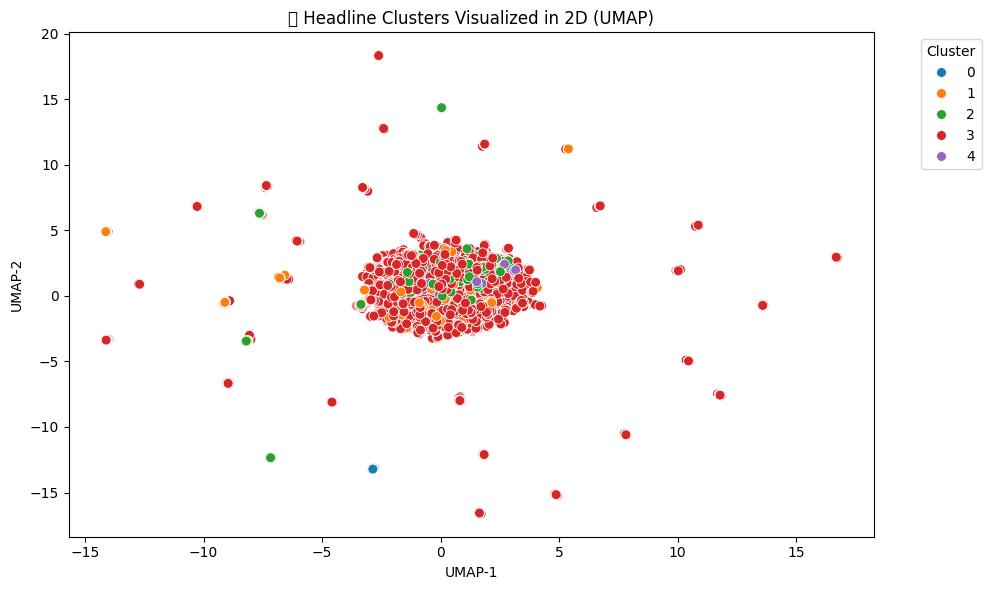

In [ ]:
import umap.umap_ as umap

# Reduce high-dimensional TF-IDF vectors to 2D
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df['cluster'], palette='tab10', s=50)
plt.title("🧭 Headline Clusters Visualized in 2D (UMAP)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-49-fee0900f6614>:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


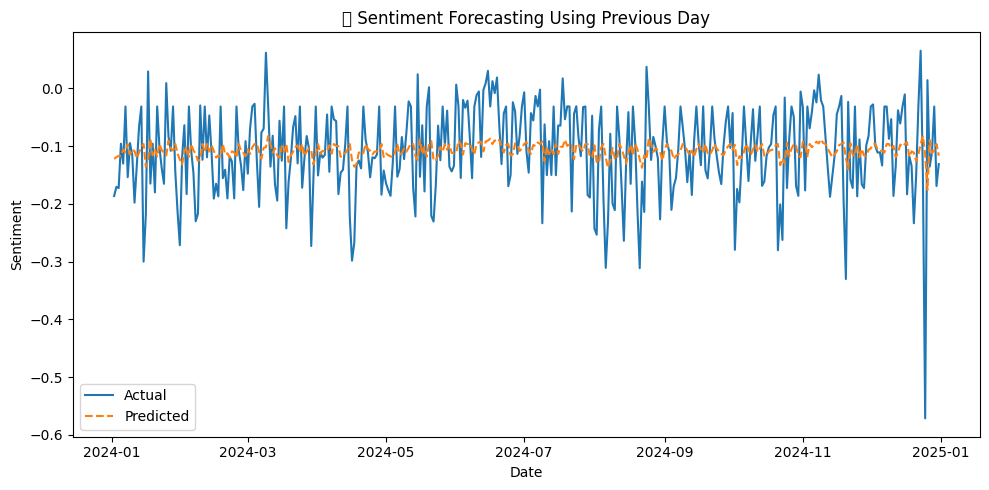

In [ ]:
# Step 1: Prepare daily sentiment
df['date'] = pd.to_datetime(df['date'])  # ensure date format
daily_sentiment = df.groupby('date')['compound'].mean().reset_index()

# Step 2: Create lag feature (yesterday's sentiment)
daily_sentiment['prev_day_sentiment'] = daily_sentiment['compound'].shift(1)

# Drop first row (NaN)
forecast_df = daily_sentiment.dropna()

# Step 3: Train a regression model
from sklearn.linear_model import LinearRegression

X = forecast_df[['prev_day_sentiment']]
y = forecast_df['compound']

model = LinearRegression()
model.fit(X, y)

# Step 4: Predict and plot
y_pred = model.predict(X)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(forecast_df['date'], y, label='Actual')
plt.plot(forecast_df['date'], y_pred, label='Predicted', linestyle='--')
plt.title("📈 Sentiment Forecasting Using Previous Day")
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(df['headline'], df['cluster'], test_size=0.2, random_state=42)

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train model
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_tfidf, y_train)

# Evaluate
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.98      1.00      0.99       202
           2       0.98      0.99      0.99       260
           3       1.00      1.00      1.00      2237
           4       1.00      0.28      0.44        25

    accuracy                           0.99      2732
   macro avg       0.99      0.85      0.88      2732
weighted avg       0.99      0.99      0.99      2732



In [ ]:
sample = ["India launches new space mission"]
sample_tfidf = vectorizer.transform(sample)
print("Predicted Cluster:", clf.predict(sample_tfidf)[0])


Predicted Cluster: 3


✅ Clustering complete. 5 clusters assigned.
💾 Saved clustered data to 'guardian_2024_sentiment_with_clusters.csv'


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-52-244366c9ecf0>:51: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


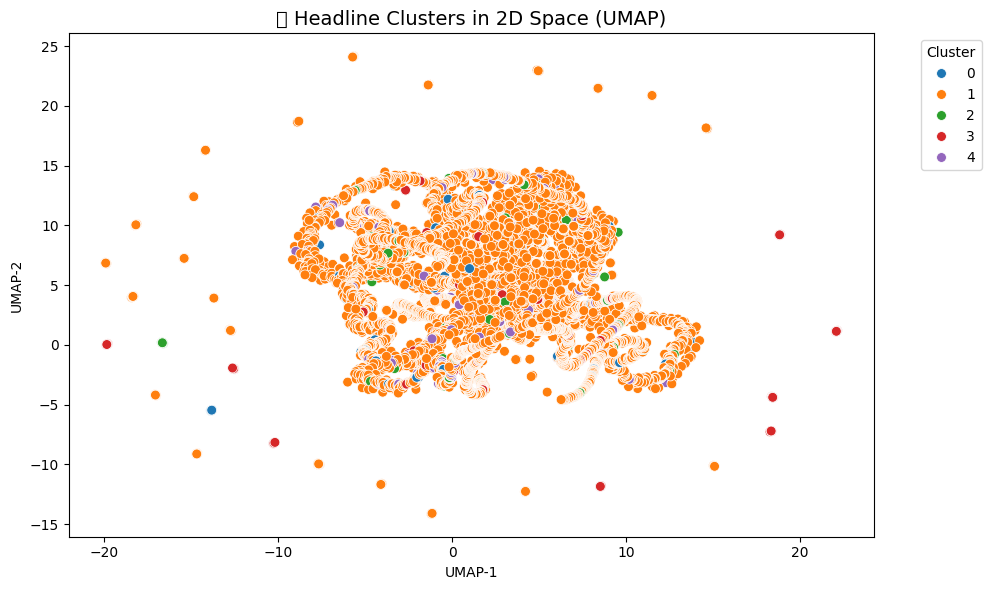

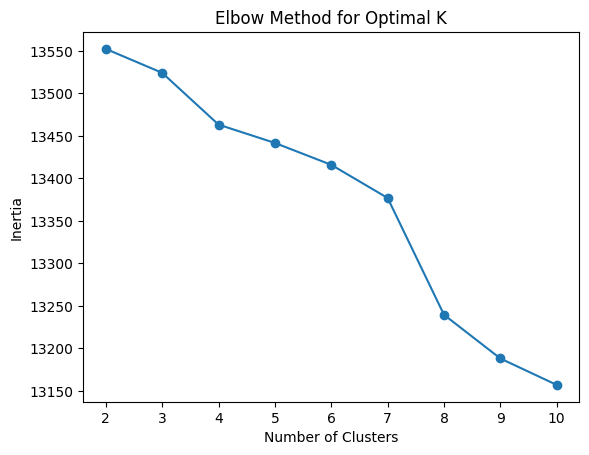

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import umap.umap_ as umap
import os

# ---------- CONFIG ----------
CSV_PATH = "guardian_2024_sentiment_with_topics.csv"
OUTPUT_PATH = "guardian_2024_sentiment_with_clusters.csv"
N_CLUSTERS = 5
MAX_FEATURES = 3000  # Optional: TF-IDF dimensionality

# ---------- LOAD DATA ----------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"File '{CSV_PATH}' not found. Ensure previous steps have been completed.")

df = pd.read_csv(CSV_PATH)
if 'headline' not in df.columns:
    raise ValueError("Missing 'headline' column in the dataset.")

# ---------- TF-IDF VECTORIZE ----------
vectorizer = TfidfVectorizer(stop_words='english', max_features=MAX_FEATURES)
X = vectorizer.fit_transform(df['headline'])

# ---------- CLUSTER ----------
if X.shape[0] < N_CLUSTERS:
    print(f"⚠️ Too few samples ({X.shape[0]}) for {N_CLUSTERS} clusters. Assigning all to cluster 0.")
    df['cluster'] = 0
else:
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init='auto')
    df['cluster'] = kmeans.fit_predict(X)
    print(f"✅ Clustering complete. {N_CLUSTERS} clusters assigned.")

# ---------- SAVE OUTPUT ----------
df.to_csv(OUTPUT_PATH, index=False)
print(f"💾 Saved clustered data to '{OUTPUT_PATH}'")

# ---------- VISUALIZATION ----------
def plot_umap(X, labels):
    reducer = umap.UMAP(random_state=42)
    X_umap = reducer.fit_transform(X)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='tab10', s=50)
    plt.title("🧭 Headline Clusters in 2D Space (UMAP)", fontsize=14)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_umap(X, df['cluster'])

# ---------- Elbow Method to Choose K ----------
# Corrected indentation for the function definition and its body
def plot_elbow(X, max_k=10):
    distortions = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    plt.plot(range(2, max_k + 1), distortions, marker='o')
    plt.title("Elbow Method for Optimal K")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.show()

plot_elbow(X)

In [ ]:
import numpy as np

def get_top_keywords_per_cluster(tfidf_vectorizer, kmeans_model, n_keywords=10):
    keywords = np.array(tfidf_vectorizer.get_feature_names_out())
    order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]

    cluster_keywords = {}
    for cluster_num in range(kmeans_model.n_clusters):
        top_terms = keywords[order_centroids[cluster_num, :n_keywords]]
        cluster_keywords[cluster_num] = top_terms.tolist()
    return cluster_keywords

# Run after clustering
cluster_keywords = get_top_keywords_per_cluster(vectorizer, kmeans)

for cluster, keywords in cluster_keywords.items():
    print(f"Cluster {cluster}: {', '.join(keywords)}")


Cluster 0: man, pleads, pardon, exotic, deported, tiger, husband, joe, king, trump
Cluster 1: uk, says, new, england, labour, israel, trump, gaza, election, eu
Cluster 2: london, announced, cannes, uprising, dogma, directors, cultural, 25, launch, khan
Cluster 3: starmer, reset, keir, brexit, eu, trump, labour, zak, starkey, drummer
Cluster 4: tax, budget, reeves, rachel, uk, hunt, labour, jeremy, rises, cuts


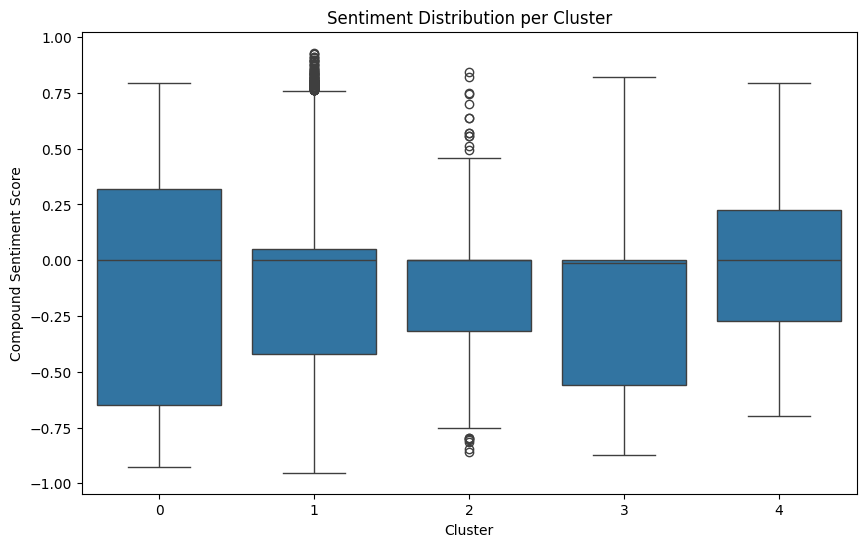

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='compound', data=df)
plt.title("Sentiment Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Compound Sentiment Score")
plt.show()


In [ ]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")

def extract_entities(texts, label):
    all_entities = []
    for doc in nlp.pipe(texts, disable=["tagger", "parser"]):
        all_entities.extend([ent.text for ent in doc.ents if ent.label_ == label])
    return Counter(all_entities).most_common(10)

for cluster_num in range(N_CLUSTERS):
    headlines = df[df['cluster'] == cluster_num]['headline'].dropna().tolist()
    top_people = extract_entities(headlines, "PERSON")
    top_orgs = extract_entities(headlines, "ORG")
    top_gpe = extract_entities(headlines, "GPE")  # Geo-political entities like countries, cities

    print(f"\nCluster {cluster_num} Entities:")
    print("Top People:", [p[0] for p in top_people])
    print("Top Organizations:", [o[0] for o in top_orgs])
    print("Top Locations:", [g[0] for g in top_gpe])


/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)



Cluster 0 Entities:
Top People: ['Tiger King', 'Joe Exotic', 'Tripoli Giannini', 'Mouse', 'Daniel Khalife', 'Joe Lewis', 'Covid', 'Dowden', 'Louis Gossett Jr', 'Oscar']
Top Organizations: ['Trump', 'Home Office', 'Hezbollah', 'Liverpool', 'Assange', 'Channel', 'Hobbycraft', 'Ex-Tesco', 'Bondi Junction', 'Northumberland’s Sycamore']
Top Locations: ['UK', 'US', 'Italy', 'Bristol', 'Israel', 'China', 'New York', 'Newcastle', 'Norfolk', 'Germany']

Cluster 1 Entities:
Top People: ['Biden', 'Netanyahu', 'Putin', 'Trump', 'Kamala Harris', 'Rishi Sunak', 'Diageo', 'Jim Morrison’s', 'Donald Tusk:', 'Dan']
Top Organizations: ['EU', 'Labour', 'Trump', 'NHS', 'UN', 'Post Office', 'Hamas', 'MoJ', 'Chelsea', 'Ryanair']
Top Locations: ['UK', 'US', 'Israel', 'Gaza', 'England', 'Ukraine', 'France', 'Russia', 'Wales', 'China']

Cluster 2 Entities:
Top People: ['Khan', 'Harry Pitman', 'London Eye', 'Andrew Lloyd Webber', 'Chaka Khan', 'Greta Thunberg', 'Fenwick', 'London Overground', 'Gove', 'Anderson'

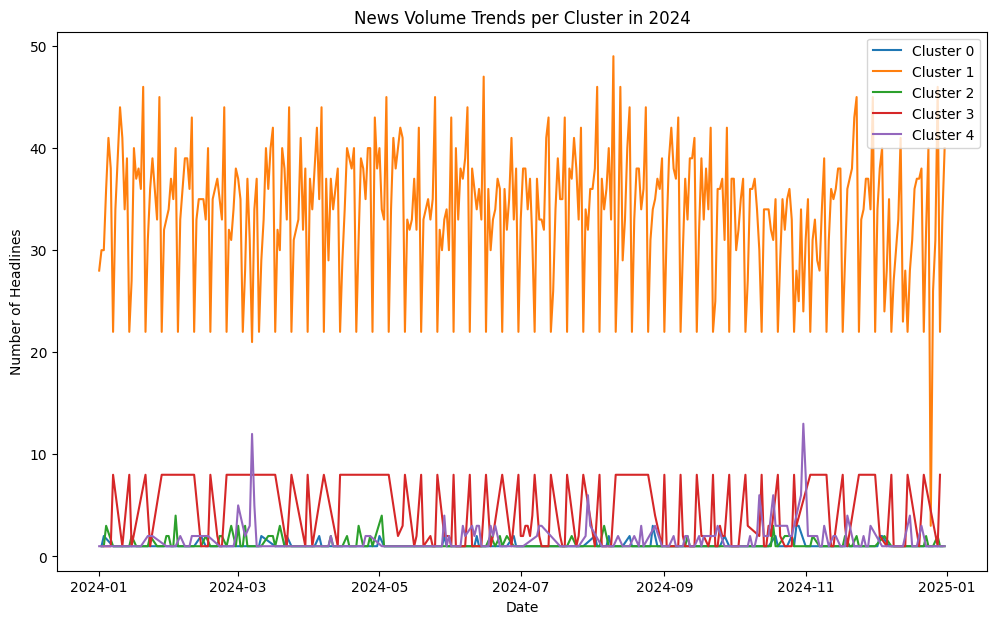

In [ ]:
df['date'] = pd.to_datetime(df['date'])  # make sure date is datetime type

cluster_date_counts = df.groupby(['date', 'cluster']).size().reset_index(name='count')

plt.figure(figsize=(12, 7))
for cluster_num in range(N_CLUSTERS):
    subset = cluster_date_counts[cluster_date_counts['cluster'] == cluster_num]
    plt.plot(subset['date'], subset['count'], label=f'Cluster {cluster_num}')

plt.title("News Volume Trends per Cluster in 2024")
plt.xlabel("Date")
plt.ylabel("Number of Headlines")
plt.legend()
plt.show()
